In [1]:
import pandas as pd 
from useful_funcs import *

# Getting dfs

In [2]:
gw1_url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2024-25/gws/gw1.csv"
gw1_df = pd.read_csv(gw1_url, index_col=0)

In [3]:
gw_df_list = []
for i in range(1, 39):
    gw_url = f"https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2024-25/gws/gw{i}.csv"
    gw_df = pd.read_csv(gw_url, index_col=0)
    gw_df['gw'] = i
    gw_df_list.append(gw_df)

In [4]:
gw_df = pd.concat(gw_df_list)

# Cleaning up dataframe

In [5]:
gw_df.columns

Index(['position', 'team', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'modified',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'starts', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'gw', 'mng_clean_sheets', 'mng_draw', 'mng_goals_scored', 'mng_loss',
       'mng_underdog_draw', 'mng_underdog_win', 'mng_win'],
      dtype='object')

In [6]:
gw_df['team_goals'] = gw_df.apply(lambda row: get_team_goals(row['was_home'], row['team_h_score'], row['team_a_score']), axis=1)
gw_df['opponent_goals'] = gw_df.apply(lambda row: get_opponent_goals(row['was_home'], row['team_h_score'], row['team_a_score']), axis=1)
gw_df['team_points'] = gw_df.apply(lambda row: get_team_points(row['was_home'], row['team_h_score'], row['team_a_score']), axis=1)
gw_df['opponent_points'] = gw_df['team_points'].apply(get_opponent_points)

In [7]:
gw_df['full_name'] = [clean_name(idx) for idx in gw_df.index]

In [8]:
gw_df.columns

Index(['position', 'team', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'modified',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'starts', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'gw', 'mng_clean_sheets', 'mng_draw', 'mng_goals_scored', 'mng_loss',
       'mng_underdog_draw', 'mng_underdog_win', 'mng_win', 'team_goals',
       'opponent_goals', 'team_points', 'opponent_points', 'full_name'],
      dtype='object')

## New

In [9]:
gw_df.columns

Index(['position', 'team', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'modified',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'starts', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'gw', 'mng_clean_sheets', 'mng_draw', 'mng_goals_scored', 'mng_loss',
       'mng_underdog_draw', 'mng_underdog_win', 'mng_win', 'team_goals',
       'opponent_goals', 'team_points', 'opponent_points', 'full_name'],
      dtype='object')

## Finding ewma for player stats

In [10]:
gw_df_players = gw_df[['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded', 'goals_scored',
                      'influence', 'creativity', 'threat', 'ict_index', 'minutes',
                        'gw', 'full_name', 'total_points', 'position', 'team', 'opponent_team']]

In [11]:
gw_df_players_reset_index = gw_df_players.reset_index()

In [12]:
# Ensure the DataFrame is sorted by 'full_name' and 'gw'
simple_gw_df_reset_index = gw_df_players_reset_index.sort_values(['full_name', 'gw'])

# List of columns to apply EWMA to
# value_cols = ['influence', 'creativity', 'threat', 'ict_index', 'team_goals', 'opponent_goals', 'minutes']
value_cols = ['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded', 'goals_scored',
                      'influence', 'creativity', 'threat', 'ict_index', 'minutes', 'total_points']

# Apply EWMA within each group
ewma_gw_df_players = (
    simple_gw_df_reset_index
    .groupby('full_name', group_keys=False)
    [value_cols]
    .apply(lambda x: x.ewm(alpha=0.3, adjust=False).mean())
)
ewma_gw_df_players.rename(columns={'total_points': 'ewma_total_points'}, inplace=True)
ewma_gw_df_players = simple_gw_df_reset_index[['full_name', 'gw', 'total_points', 'position','team','opponent_team']].join(ewma_gw_df_players)

## Finding ewma for team stats

In [13]:
gw_df.columns

Index(['position', 'team', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'modified',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'starts', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'gw', 'mng_clean_sheets', 'mng_draw', 'mng_goals_scored', 'mng_loss',
       'mng_underdog_draw', 'mng_underdog_win', 'mng_win', 'team_goals',
       'opponent_goals', 'team_points', 'opponent_points', 'full_name'],
      dtype='object')

In [14]:
gw_df_team = gw_df[['team', 'gw', 'team_goals']]



In [15]:
gw_df_team2 = gw_df_team.groupby(['team', 'gw']).first().reset_index()

In [16]:
# Ensure the DataFrame is sorted by 'full_name' and 'gw'
gw_df_team_sorted = gw_df_team2.sort_values(['team', 'gw'])

# List of columns to apply EWMA to
# value_cols = ['influence', 'creativity', 'threat', 'ict_index', 'team_goals', 'opponent_goals', 'minutes']
value_cols = ['team_goals']

# Apply EWMA within each group
ewma_gw_df_team = (
    gw_df_team_sorted
    .groupby('team', group_keys=False)
    [value_cols]
    .apply(lambda x: x.ewm(alpha=0.3, adjust=False).mean())
)

ewma_gw_df_team.rename(columns={'team_goals': 'ewma_team_goals'}, inplace=True)
ewma_gw_df_team = gw_df_team_sorted[['team', 'gw']].join(ewma_gw_df_team)

## Merging team and player ewma

In [17]:
teams_url = 'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2024-25/teams.csv'
teams = pd.read_csv(teams_url)

teamcode_dict = dict(zip(teams['id'], teams['name']))
ewma_gw_df_players['opponent_team_name'] = ewma_gw_df_players['opponent_team'].map(teamcode_dict)

In [18]:
ewma_gw_df_players

,full_name,gw,total_points,position,team,opponent_team,assists,bonus,bps,clean_sheets,goals_conceded,goals_scored,influence,creativity,threat,ict_index,minutes,ewma_total_points,opponent_team_name
17247,aaron_anselmino,25,0,DEF,Chelsea,5,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Brighton
18040,aaron_anselmino,26,0,DEF,Chelsea,2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Aston Villa
18823,aaron_anselmino,27,0,DEF,Chelsea,17,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Southampton
19611,aaron_anselmino,28,0,DEF,Chelsea,11,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Leicester
20269,aaron_anselmino,29,0,DEF,Chelsea,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Arsenal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24333,zain_silcott_duberry,34,0,MID,Bournemouth,14,0.0,0.0,0.029660,0.0,0.0,0.0,0.011864,0.005932,0.0,0.001780,0.005932,0.005932,Man Utd
25118,zain_silcott_duberry,35,0,MID,Bournemouth,1,0.0,0.0,0.020762,0.0,0.0,0.0,0.008305,0.004152,0.0,0.001246,0.004152,0.004152,Arsenal
25919,zain_silcott_duberry,36,0,MID,Bournemouth,2,0.0,0.0,0.014533,0.0,0.0,0.0,0.005813,0.002907,0.0,0.000872,0.002907,0.002907,Aston Villa
26720,zain_silcott_duberry,37,0,MID,Bournemouth,13,0.0,0.0,0.010173,0.0,0.0,0.0,0.004069,0.002035,0.0,0.000610,0.002035,0.002035,Man City


In [19]:
ewma_gw_df_opponent_team = ewma_gw_df_team.rename(columns={'team': 'opponent_team_name', 'ewma_team_goals': 'ewma_nw_opponent_goals'})

In [20]:
ewma_gw_df = ewma_gw_df_players.merge(ewma_gw_df_team, on=['team', 'gw'], how='left')
# ewma_gw_df = ewma_gw_df.merge(ewma_gw_df_opponent_team, on=['opponent_team_name', 'gw'], how='left')

In [21]:
ewma_gw_df['nw_total_points'] = (
    ewma_gw_df
    .sort_values(['full_name', 'gw'])
    .groupby('full_name')['total_points']
    .shift(-1)
)

ewma_gw_df['nw_opponent'] = (
    ewma_gw_df
    .sort_values(['full_name', 'gw'])
    .groupby('full_name')['opponent_team_name']
    .shift(-1)
)

In [22]:
ewma_gw_df2 = ewma_gw_df.merge(ewma_gw_df_opponent_team, on=['opponent_team_name', 'gw'], how='left')

# Trying some models

## Random forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
ewma_gw_df3 = ewma_gw_df2.dropna(subset=['nw_total_points'])
non_zero_players = ewma_gw_df3.groupby('full_name').sum().query('total_points>0').index
ewma_gw_df3 = ewma_gw_df3.query('full_name in @non_zero_players')
ewma_gw_df3 = ewma_gw_df3.query('gw>9')

In [25]:
ewma_gw_df3_fwd = ewma_gw_df3.query('position=="FWD"').set_index(['full_name', 'gw'])

X = ewma_gw_df3_fwd[[
       'assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
       'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
       'minutes', 'ewma_total_points', 'ewma_team_goals',
       'ewma_nw_opponent_goals']]

y = ewma_gw_df3_fwd['nw_total_points']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [27]:
model = RandomForestClassifier(random_state=0, n_estimators=300, max_depth=10)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=0)

In [28]:
y_pred = model.predict(X_test)

In [29]:
from sklearn.metrics import accuracy_score

print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.6165


# Lin regress

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [32]:
y_pred = model.predict(X_test)

In [33]:
y_test_df = y_test.to_frame(name='y_test')
y_test_df['y_pred'] = y_pred

<Axes: xlabel='y_test', ylabel='y_pred'>

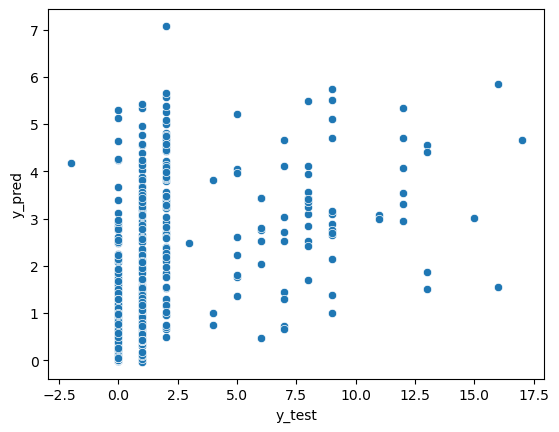

In [34]:
from scipy.stats import linregress

sns.scatterplot(data=y_test_df, x='y_test', y='y_pred')

In [35]:
linregress(y_test_df['y_test'], y_test_df['y_pred'])

LinregressResult(slope=np.float64(0.24358941893210104), intercept=np.float64(1.300441534058131), rvalue=np.float64(0.4649437370655938), pvalue=np.float64(4.468190785902254e-28), stderr=np.float64(0.020827031689968824), intercept_stderr=np.float64(0.07338585014377337))

## Eval a load of models

In [36]:
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
# from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error


for pos in ['FWD', 'MID', 'DEF', 'GK']:
	print(pos)
	ewma_gw_df3_fwd = ewma_gw_df3.query('position==@pos').set_index(['full_name', 'gw'])

	X = ewma_gw_df3_fwd[[
		'assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
		'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
		'minutes', 'ewma_total_points', 'ewma_team_goals',
		'ewma_nw_opponent_goals']]

	y = ewma_gw_df3_fwd['nw_total_points']

	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

	models = []
	models.append(('LR', LinearRegression()))
	# models.append(('DT', DecisionTreeClassifier()))
	# models.append(('RF', RandomForestClassifier()))
	# models.append(('SVR', SVR()))
	# models.append(('KNN', KNeighborsRegressor()))
	# models.append(('XGB', XGBRegressor(objective='reg:squarederror')))

	for name, model in models:
		model.fit(X_train, y_train)
		y_pred = model.predict(X_test)
		mse = root_mean_squared_error(y_test, y_pred)

		print(model)
		print(mse)

FWD
LinearRegression()
2.698045800071004
MID
LinearRegression()
2.1827289313829907
DEF
LinearRegression()
2.1528673846055226
GK
LinearRegression()
2.2320623853454715


In [37]:
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

for pos in ['FWD', 'MID', 'DEF', 'GK']:
	
    # print(pos)
	# ewma_gw_df3_fwd = ewma_gw_df3.query('position==@pos').set_index(['full_name', 'gw'])

	# X = ewma_gw_df3_fwd[[
	# 	'assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
	# 	'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
	# 	'minutes', 'ewma_total_points', 'ewma_team_goals',
	# 	'ewma_nw_opponent_goals']]

	# y = ewma_gw_df3_fwd['nw_total_points']

	# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

    print(pos)
    ewma_gw_df3_fwd = ewma_gw_df3.query('position==@pos').set_index(['full_name', 'gw'])

    X = ewma_gw_df3_fwd[[
    'assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
    'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
    'minutes', 'ewma_total_points', 'ewma_team_goals',
    'ewma_nw_opponent_goals']]
    y = ewma_gw_df3_fwd['nw_total_points']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

    params = {
            'max_depth': list(range(3,7)),  
        'min_child_weight': list(range(10,51)),
        'learning_rate':  [0.03, 0.15, 0.3, 0.45, 0.6],
        'subsample': stats.uniform(0.8, 0.1),
        'colsample_bytree': [0.8, 0.1]}

    xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')
    xgb_reg.fit(X_train, y_train)

    xgb_cv = RandomizedSearchCV(xgb_reg, params, cv=3, scoring='neg_root_mean_squared_error',
                                random_state=999)

    xgb_cv.fit(X_train, y_train)
    xgb_best = xgb.XGBRegressor(objective='reg:squarederror')
    xgb_best.set_params(**xgb_cv.best_params_)

    xgb_best.fit(X_train, y_train)
    y_pred = xgb_best.predict(X_test)
    mse = root_mean_squared_error(y_test, y_pred)

    print(mse)

FWD
2.704989067249157
MID
2.1881873601294157
DEF
2.120749552554571
GK
2.294599992488086
